In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from PIL import Image
import ipywidgets as widgets
from io import BytesIO
from IPython.display import display
import matplotlib as mpl

# Defining Environment

In [2]:
## Parameters for drawing the map

WALL_MAP_VALUE = 1
REWARD_MAP_VALUE = 2
EXIT_MAP_VALUE = 3
REWARD_SPARSITY = 0.1

In [3]:
def create_corridor(CORRIDOR_SHAPE, SEED = 42):
    """creates an array corresponding to a corridor of the level"""
    # instantiate corridor with rewards
    np.random.seed(SEED)
    corridor = np.random.choice([REWARD_MAP_VALUE, 0], size = CORRIDOR_SHAPE, p = [REWARD_SPARSITY, 1-REWARD_SPARSITY])

    # add walls
    SPACE = 5
    GAP = 2
    GAP_UP = -1
    GAP_DOWN = -2

    wall_x = SPACE
    orientation = GAP_UP

    while wall_x < CORRIDOR_SHAPE[0]:
        if orientation == GAP_UP: 
            corridor[wall_x, GAP:] = WALL_MAP_VALUE
            orientation = GAP_DOWN
        elif orientation == GAP_DOWN:
            corridor[wall_x, :-GAP] = WALL_MAP_VALUE
            orientation = GAP_UP
        wall_x += SPACE
        
    # place exit at the end of corridor and remove existing walls
    corridor[-1, :] = 0
    corridor[-1, CORRIDOR_SHAPE[1]//2] = EXIT_MAP_VALUE
    
        
    return corridor

def create_map(CORRIDOR_SHAPE, corridors):
    """creates a map from a list of corridors."""
    size = 2*CORRIDOR_SHAPE[0] + CORRIDOR_SHAPE[1] 
    center_xy = int((size - 1)/ 2)
    
    terrain = np.ones((size, size))
    
    # add right corridor
    if True:
        i = 0
        start_x  = int(center_xy + (CORRIDOR_SHAPE[1])/2) + 1
        end_x = int(start_x + CORRIDOR_SHAPE[0])

        start_y = int(center_xy - (CORRIDOR_SHAPE[1]-1)/2)
        end_y = int(start_y + CORRIDOR_SHAPE[1])

        terrain[start_x:end_x, start_y : end_y] = rotate(corridors[i], angle = 90*i)
    
    # add top corridor
    if True:
        i = 1
        start_x  = int(center_xy - (CORRIDOR_SHAPE[1]-1)/2)
        end_x = int(start_x + CORRIDOR_SHAPE[1])

        start_y = int(center_xy + (CORRIDOR_SHAPE[1]-1)/2) + 1
        end_y = int(start_y + CORRIDOR_SHAPE[0])

        terrain[start_x:end_x, start_y : end_y] = rotate(corridors[i], angle = 90*i)

    # add left corridor
    if True:
        i = 2
        start_x  = 0
        end_x = int(start_x + CORRIDOR_SHAPE[0])

        start_y = int(center_xy - (CORRIDOR_SHAPE[1]-1)/2) 
        end_y = int(start_y + CORRIDOR_SHAPE[1])

        terrain[start_x:end_x, start_y : end_y] = rotate(corridors[i], angle = 90*i)

    # add bottom corridor
    if True:
        i = 3
        start_x  = int(center_xy - (CORRIDOR_SHAPE[1]-1)/2)
        end_x = int(start_x + CORRIDOR_SHAPE[1])

        end_y = int(center_xy - (CORRIDOR_SHAPE[1]-1)/2)
        start_y = int(start_y - CORRIDOR_SHAPE[0])

        terrain[start_x:end_x, start_y : end_y] = rotate(corridors[i], angle = 90*i)
  
    # add Fork from starting position
    if True:
        terrain[center_xy , center_xy - CORRIDOR_SHAPE[1]//2: center_xy + CORRIDOR_SHAPE[1] //2 + 1] = 0
        terrain[center_xy - CORRIDOR_SHAPE[1]//2: center_xy + CORRIDOR_SHAPE[1] //2 + 1, center_xy] = 0
        
    return terrain
    
def create_env(CORRIDOR_SHAPE, SEEDS = [42, 43, 44, 45]):
    """creates both the corridors and the map."""
    corridors = [create_corridor(CORRIDOR_SHAPE, SEEDS[i]) for i in range(4)]
    env = create_map(CORRIDOR_SHAPE, corridors)
    return env
    

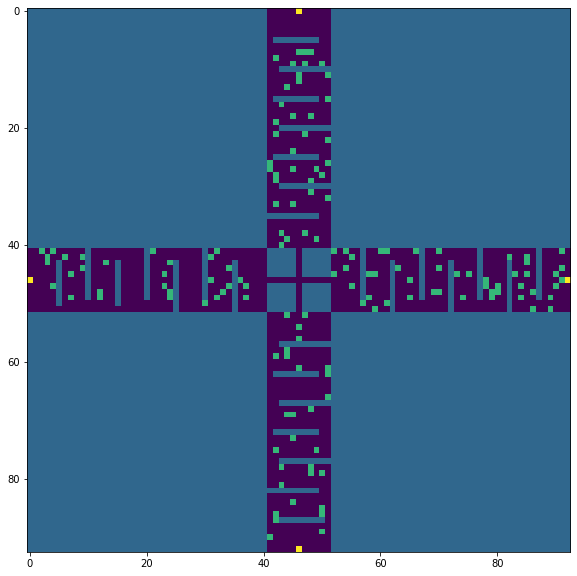

In [4]:
SEEDS = [42, 43, 44, 45]
CORRIDOR_SHAPE = (41, 11) # should be odd numbers for perfect symmetry


env = create_env(CORRIDOR_SHAPE, SEEDS)
plt.imshow(rotate(env, angle= 90))
fig = plt.gcf()
fig.set_size_inches(10,10)

# Yellow : Exit
# Green : Rewards
# Blue : Walls (unexplorable coordinates)

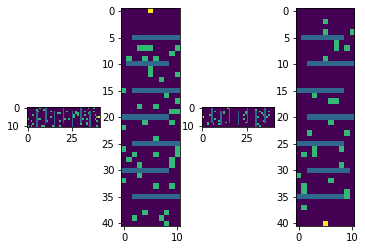

In [5]:
corridors = [create_corridor(CORRIDOR_SHAPE, SEEDS[i]) for i in range(4)]
for i, corridor in enumerate(corridors):
    plt.subplot(1, 4, i+1)
    plt.imshow(rotate(corridor.T, angle = 90*i))

## Define Agent

In [6]:
class Agent():
    def __init__(self, CORRIDOR_SHAPE):
        size = 2*CORRIDOR_SHAPE[0] + CORRIDOR_SHAPE[1] 
        center_xy = int((size - 1)/ 2)
        self.x = center_xy
        self.y = center_xy
    
    def action(self, choice):
        if choice == 0:
            # go left
            self.__move__(-1, 0)
        if choice == 1:
            # go up
            self.__move__(0, 1)
        if choice == 2:
            # go right:
            self.__move__(1, 0)
        if choice == 3:
            # go down
            self.__move__(0, -1)
        return
    
    def __move__(self, x, y):
        self.x += x
        self.y += y
        return
    
    def get_coords(self):
        return (self.x, self.y)

In [67]:
class Phase1():
    def __init__(self, CORRIDOR_SHAPE = (21, 11), SEEDS = [42, 43, 44, 45]):
        # HYPERPARAMETERS
        self.EXPLORE_ITER          = 200
        self.W1                    = 1    # weight of # of times chosen attribute
        self.W2                    = 1    # weight of # of times seen attribute
        self.W3                    = 1    # weight of # of times chosen since it has led to a new discovery attribute
        self.P1                    = 2   
        self.P2                    = 2
        self.P3                    = 2
        self.E1                    = 1e-1
        self.E2                    = 1e-1
        self.WN_HORIZONTAL         = 10
        self.WN_VERTICAL           = 10
        self.WN_REWARD             = 100
        
        # Initialization
        self.env = create_env(CORRIDOR_SHAPE, SEEDS)
        self.MAX_SCORE = len(np.where(self.env == REWARD_MAP_VALUE)[0])
        self.agent = Agent(CORRIDOR_SHAPE = CORRIDOR_SHAPE)
        self.archive = {}               # contains the trajectory of actions leading to a cell
        self.cell_attributes = {}       # contains the three attributes of the cells
        self.cell_scores = {}           # contains the cell scores
        self.cell_states = {}           # contains the state of the environment and the position of the agent
        self.cell_cumulative_scores = {} # contains the cumulative score obtained at a given cell
        self.xys = {}
        
        # Add initial cell to archive
        size = 2*CORRIDOR_SHAPE[0] + CORRIDOR_SHAPE[1] 
        center_xy = int((size - 1)/ 2)
        cell_key = "{},{}".format(center_xy, center_xy)
        
        self.archive[cell_key] = []
        self.cell_attributes[cell_key] = [0, 0, 0]
        self.cell_scores[cell_key] = 1
        self.cell_states[cell_key] = [self.env.copy(), self.agent.get_coords()]
        self.cell_cumulative_scores[cell_key] = 0
        self.xys[cell_key] = [(center_xy, center_xy)]
        
    def choose_cell(self):
        """Chooses a cell randomly from the archive."""
        # reset seed
        np.random.seed()
        
        keys = list(self.cell_scores.keys())
        scores = list(self.cell_scores.values())
        
        chosen_cell_key = np.random.choice(keys, size = 1, p = scores)[0]
        chosen_cell_x = chosen_cell_key.split(',')[0]
        chosen_cell_y = chosen_cell_key.split(',')[1]
        
        # update number of times a cell has been chosen as a cell to explore from
        self.cell_attributes[chosen_cell_key][0] += 1
        
        return (chosen_cell_x, chosen_cell_y)
    
    def store_cell(self, c, trajectory, cumulative_score, agent_xy):
        """Adds a cell c and the trajectory of actions that led to c to the archive."""
        cell_key = "{},{}".format(c[0], c[1])
        
        self.xys[cell_key] = agent_xy.copy()
        self.archive[cell_key] = trajectory.copy()
        #print("cumulative_score", cumulative_score)
        self.cell_cumulative_scores[cell_key] = cumulative_score
        #print(len(np.where(self.env == REWARD_MAP_VALUE)[0]))
        self.cell_states[cell_key] = [self.env.copy(), self.agent.get_coords()]
        try:
            # assert if cell was already in the archive. This is done to keep the metadata of the cell intact.
            len(self.cell_attributes[cell_key])
        except:
            # if it was not then set its attributes to 0 and its score to 0
            self.cell_attributes[cell_key] = [0, 0, 0]
            self.cell_scores[cell_key] = 0
            
        return
        
    def should_store(self, c, trajectory, cumulative_score, agent_xy):
        """Assesses whether a cell c and the trajectory of actions that led to c shoud be stored in the archive."""
        cell_key = "{},{}".format(c[0], c[1])
        if not cell_key in list(self.xys):
            return True
        
        # if the cell was already in the archive then it should be added if 
        #    i) the trajectory is shorter
        #   ii) the cumulative score is higher

        length_old_trajectory = len(self.xys[cell_key])
        length_new_trajectory = len(agent_xy)

        if length_new_trajectory < length_old_trajectory:
            if cumulative_score >= self.cell_cumulative_scores[cell_key]:
                #print("lengths:", length_old_trajectory, length_new_trajectory)
                return True

        if cumulative_score > self.cell_cumulative_scores[cell_key]:
            #print("old score", self.cell_cumulative_scores[cell_key], "new score", cumulative_score)
            return True        
        return False
        
        
    def explore(self):
        """Launches exploration procedure."""
        # reset seed
        np.random.seed()
        
        self.agent = Agent(self.env.shape)
        starting_cell = self.choose_cell()
        starting_cell_key = "{},{}".format(starting_cell[0], starting_cell[1])
        
        self.agent.x = self.cell_states[starting_cell_key][1][0]
        self.agent.y = self.cell_states[starting_cell_key][1][1]
        self.env = self.cell_states[starting_cell_key][0].copy()
        cumulative_score = self.cell_cumulative_scores[starting_cell_key]
        trajectory = self.archive[starting_cell_key].copy()
        agent_xy = self.xys[starting_cell_key].copy()

        has_discovered = False
        
        oob_x = np.where(self.env[0] == 1)[0]
        oob_y = np.where(self.env[:,0] == 1)[0]

        oob = []
        for x in oob_x:
            for y in oob_y:
                oob.append((x, y))
        
        # Launch exploration
        for k in range(self.EXPLORE_ITER):
            # assess if oob
            if (self.agent.x, self.agent.y) in oob:
                print("OUT OF BOUNDS")
            
            
            # assess available actions
            possible_actions, _ = self.get_possible_actions(self.agent.x, self.agent.y)
            n = len(possible_actions)
            
            # choose an action randomly
            choice = np.random.choice(possible_actions, size = 1, p = [1/n] * n)[0]
            self.agent.action(choice)
                        
            # assess if agent has left the map
            if self.env[self.agent.x, self.agent.y] == EXIT_MAP_VALUE:
                break
            
            # update cell metadata
            reward = self.get_reward()
            if reward == 1:
                cumulative_score += reward
                self.env[self.agent.x, self.agent.y] = 0
    
            trajectory.append(choice)
            agent_xy.append(self.agent.get_coords())
            c = (self.agent.x, self.agent.y)
            cell_key ="{},{}".format(c[0], c[1])
            
            # store cell
            if self.should_store(c, trajectory, cumulative_score, agent_xy):
                self.store_cell(c, trajectory, cumulative_score, agent_xy)
                # reset number of times a cell has been chosen since it last produced the discovery of a new or better cell
                self.cell_attributes[starting_cell_key][2] = 0
                has_discovered = True
            
            # update number of times a cell was visited at any point during phase 1
            self.cell_attributes[cell_key][1] += 1
        ### END OF EXPLORATION
        
        # update number of times the starting cell has been chosen since it last produced the discovery of a new or better cell
        if has_discovered == False:
            self.cell_attributes[starting_cell_key][2] += 1
        
        self.compute_cell_scores()
        return
            
    def get_reward(self):
        x, y = self.agent.x, self.agent.y
        if self.env[x, y] == REWARD_MAP_VALUE:
            return 1
        else:
            return 0
            
    def get_possible_actions(self, x, y):
        """Assesses the possible actions available to the agent."""        
        choices = []
        neighbors = []
        if x - 1 >= 0:
            if self.env[x-1, y] != WALL_MAP_VALUE:
                choices.append(0)
                neighbors.append((x-1, y))
        
        if y + 1 < self.env.shape[1]:
            if self.env[x, y+1] != WALL_MAP_VALUE:
                choices.append(1)
                neighbors.append((x, y+1))
        
        if x + 1 < self.env.shape[0]:
            if self.env[x+1, y] != WALL_MAP_VALUE:
                choices.append(2)
                neighbors.append((x+1, y))
        
        if y - 1 >= 0:
            if self.env[x, y-1] != WALL_MAP_VALUE:
                choices.append(3)
                neighbors.append((x, y-1))
                
        return choices, neighbors
    
    def cell_count_score(self, c):
        """Computes the Count Score of a given cell."""
        cell_key = "{},{}".format(c[0], c[1])
        attribute_values = np.array(self.cell_attributes[cell_key])
        attribute_weights = np.array([self.W1, self.W2, self.W3])
        attribute_powers = np.array([self.P1, self.P2, self.P3])
        
        scores = attribute_weights * ((attribute_values + self.E1)**-attribute_powers)
        
        return scores.sum() + self.E2
        
    def cell_neighbor_score(self, c):
        """Computes the Neighbor Score of a given cell."""
        _, neighbors = self.get_possible_actions(*c)
        scores = np.zeros(4)
        
        for i,neighbor in enumerate(neighbors):
            try:
                neighbor_key = "{},{}".format(neighbor[0], neighbor[1])
                len(self.archive[neighbor_key])
            except:
                # if this neighbor is new add associated score
                if self.env[neighbor] == REWARD_MAP_VALUE:
                    scores[i] = self.WN_REWARD
                elif i == 0 or i == 2:
                    scores[i] = self.WN_HORIZONTAL
                else:
                    scores[i] = self.WN_VERTICAL
        return scores.sum()
    
    def compute_cell_scores(self):
        """Computes the scores of every cell in the archive."""
        cell_keys = list(self.archive.keys())
        cell_scores = np.zeros(len(cell_keys))
        
        for i,cell_key in enumerate(cell_keys):
            c = (int(cell_key.split(',')[0]), int(cell_key.split(',')[1]))
            cell_scores[i] = self.cell_count_score(c) + self.cell_neighbor_score(c) + 1
        
        cell_scores = cell_scores / cell_scores.sum()
        
        for i, cell_key in enumerate(cell_keys):
            self.cell_scores[cell_key] = cell_scores[i]        
        
        return

In [8]:

def get_best_trajectory(phase1):
    """Returns a tuple of (x,y) tuples in the trajectory that got the best score"""
    max_score = -1
    cell = next(iter(phase1.cell_cumulative_scores.keys()))
    for key, value in phase1.cell_cumulative_scores.items():
        if value >= max_score and len(phase1.xys[key]) < len(phase1.xys[cell]):
            cell = key
        elif value > max_score:
            max_score = value
            cell = key

    path = phase1.xys[cell]
    real_trajectory_x = []
    real_trajectory_y = []

    for xy in path:
        real_trajectory_x.append(xy[0])
        real_trajectory_y.append(xy[1])

    real_trajectory_x = tuple(real_trajectory_x)
    real_trajectory_y = tuple(real_trajectory_y)

    real_trajectory = tuple([real_trajectory_x, real_trajectory_y])
    return real_trajectory


def get_best_trajectory_matrix(phase1):
    max_score = -1
    cell = next(iter(phase1.cell_cumulative_scores.keys()))
    for key, value in phase1.cell_cumulative_scores.items():
        if value >= max_score and len(phase1.xys[key]) < len(phase1.xys[cell]):
            cell = key
        elif value > max_score:
            max_score = value
            cell = key

    path = phase1.xys[cell]
    real_trajectory_x = []
    real_trajectory_y = []

    for xy in path:
        real_trajectory_x.append(xy[0])
        real_trajectory_y.append(xy[1])

    real_trajectory_x = tuple(real_trajectory_x)
    real_trajectory_y = tuple(real_trajectory_y)
    real_trajectory = tuple([real_trajectory_x, real_trajectory_y])

    env2 = phase1.cell_states[cell][0].copy()
    env2[real_trajectory] = EXIT_MAP_VALUE
    env2 = (env2 - env2.min()) / env2.max() * 255
    return env2


def get_neighbor_score_matrix(phase1):
    score_matrix = np.zeros(phase1.env.shape)
    for key in phase1.cell_scores.keys():
        x = int(key.split(",")[0])
        y = int(key.split(",")[1])
        score_matrix[x, y] = phase1.cell_neighbor_score((x, y))

    min_score = score_matrix[score_matrix > 0].min()
    max_score = score_matrix.max()
    score_matrix = (score_matrix - min_score) / max_score

    return score_matrix


def get_score_matrix(phase1):
    score_matrix = np.zeros(phase1.env.shape)

    for key, value in phase1.cell_scores.items():
        x = int(key.split(",")[0])
        y = int(key.split(",")[1])
        score_matrix[x, y] = value

    min_score = score_matrix[score_matrix > 0].min()
    max_score = score_matrix.max()
    # print(min_score, max_score)
    score_matrix = (score_matrix - min_score) / max_score * 255
    return score_matrix


def save_score_matrix(phase1, i):
    score_matrix = get_score_matrix(phase1)
    score_matrix = np.array(Image.fromarray(score_matrix).resize((512, 512)))
    path = "./score_matrix/score_matrix_" + str(i) + ".jpg"
    plt.imsave(path, score_matrix, cmap='gray')
    return path


def save_neighbor_score_matrix(phase1, i):
    score_matrix = get_neighbor_score_matrix(phase1)
    score_matrix = np.array(Image.fromarray(score_matrix).resize((512, 512)))
    path = "./neigh_score_matrix/score_matrix_" + str(i) + ".jpg"
    plt.imsave(path, score_matrix, cmap='gray')
    return path


def save_trajectory(phase1, i):
    trajectory = get_best_trajectory(phase1)
    env = phase1.env.copy()
    env[trajectory] = EXIT_MAP_VALUE
    env = np.array(Image.fromarray(env).resize((512, 512)))
    plt.imsave("./trajectory/trajectory_" + str(i) + ".jpg",
               env, cmap='gray')

In [9]:
def arr2bytes(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', mpl.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control overall luminosity
    vmax = 255 if arr.dtype == 'uint8' else 1.0
    with BytesIO() as buffer:
        mpl.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=0, vmax=vmax)
        out = buffer.getvalue()
    return out

In [10]:
from tqdm import tqdm_notebook

CORRIDOR_SHAPE = (21, 11) ## needs to be odd

phase1 = Phase1(CORRIDOR_SHAPE)

N_STEPS = 10000
SAVE_EVERY = 50


neighscore_widget = widgets.Image(
    value=arr2bytes(np.array(Image.fromarray(get_neighbor_score_matrix(phase1)).resize((512,512)))),
    format='jpg',
    width=256,
    height=256,
)

trajectory_widget = widgets.Image(
    value=arr2bytes(np.array(Image.fromarray(get_best_trajectory_matrix(phase1)).resize((512,512)))),
    format='jpg',
    width=256,
    height=256,
)

step_widget = widgets.IntSlider(min = 0,
                                max = N_STEPS,
                                value = 0,
                                disabled = True)

display(widgets.HBox([neighscore_widget, trajectory_widget]))

best_scores = []
for i in tqdm_notebook(range(N_STEPS)):
   # step_widget.value = i
    if i % SAVE_EVERY == 0:
        save_path = save_score_matrix(phase1, i)
        save_trajectory(phase1, i)
        file = open(save_path, "rb")
        image = file.read()
        max_score = -1
        for key,value in phase1.cell_cumulative_scores.items():
            if value > max_score:
                max_score = value
                cell = key
        
        neighscore_widget.value=arr2bytes((np.array(Image.fromarray(get_score_matrix(phase1)).resize((256,256)))))
        file.close()
        trajectory_widget.value=arr2bytes((np.array(Image.fromarray(get_best_trajectory_matrix(phase1)).resize((256,256)))))
    
    phase1.explore()
    
    best_score = max(phase1.cell_cumulative_scores.values())
    best_scores.append(best_score)
    

max_score = -1
for key,value in phase1.cell_cumulative_scores.items():
    if value > max_score:
        max_score = value
        cell = key

path = phase1.xys[cell]
real_trajectory_x = []
real_trajectory_y = []

for xy in path:
    real_trajectory_x.append(xy[0])
    real_trajectory_y.append(xy[1])
    
real_trajectory_x = tuple(real_trajectory_x)
real_trajectory_y = tuple(real_trajectory_y)

real_trajectory = tuple([real_trajectory_x, real_trajectory_y])
            

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [16:59<00:00,  9.81it/s]


## Animate Exploration

In [12]:
### Make GIF of run
import imageio
import glob
import re


def tryint(s):
    try:
        return int(s)
    except:
        return s


def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [tryint(c) for c in re.split('([0-9]+)', s)]


def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)


path = './'
filenames1 = [f for f in glob.glob(path + "score_matrix/*", recursive=True)]
filenames2 = [f for f in glob.glob(path + "trajectory/*", recursive=True)]
sort_nicely(filenames1)
sort_nicely(filenames2)

with imageio.get_writer('run2.gif', mode='I') as writer:
    for filename1, filename2 in zip(filenames1, filenames2):
        image1 = imageio.imread(filename1)
        image2 = imageio.imread(filename2)
        writer.append_data(np.concatenate([image1, image2], axis=1))

## Save Best Run

In [21]:
best_run = phase1.archive[cell]

In [ ]:
with open("best_run.csv", "w") as file:
    for i in range(len(best_run)):
        string  = str(best_run[i]) + ",\n"
        file.write(string)

## Import Best Run

In [59]:
import pandas as pd
X = pd.read_csv("best_run.csv", header = None)
best_run1 = X.drop([1], axis = 1).to_numpy().flatten()

In [61]:
(best_run == best_run1).all()

True

## Animate Best Run

In [115]:
from tqdm import tqdm_notebook

In [95]:
i = 100


In [138]:
SEEDS = [42, 43, 44, 45]
CORRIDOR_SHAPE = (21, 11) # should be odd numbers for perfect symmetry

# trajectory of the agent
agent_xy = phase1.xys[cell]
trajectory_tail = 10
alphas = np.linspace(0, 1, 11) ** 2


for i in tqdm_notebook(range(len(agent_xy))):
    env = create_env(CORRIDOR_SHAPE, SEEDS)
    tail = np.array(agent_xy[max(0, i-trajectory_tail):i+1])
    tail = (tuple(tail[:,0]), tuple(tail[:,1]))

    trajectory = np.array(agent_xy[:i+1])
    trajectory = (tuple(trajectory[:,0]), tuple(trajectory[:,1]))

    env[trajectory] = 0
    env[tail] = EXIT_MAP_VALUE * alphas[-min(trajectory_tail + 1, i+1):]
    env = np.array(Image.fromarray(env).resize((512, 512)))
    plt.imsave("./best_run/trajectory_{}.jpg".format(i), env, cmap = 'gray')
    


KeyboardInterrupt: 

In [113]:
path = './'
filenames = [f for f in glob.glob(path + "best_run/*", recursive=True)]
sort_nicely(filenames)


with imageio.get_writer('agent_run.gif', mode='I') as writer:
    for filename in tqdm(filenames):
        image = imageio.imread(filename)
        writer.append_data(image)

100%|██████████████████████████████████████████████████████████████████████████████| 6824/6824 [09:38<00:00, 11.79it/s]


In [123]:
env = (env - env.min())/env.max()

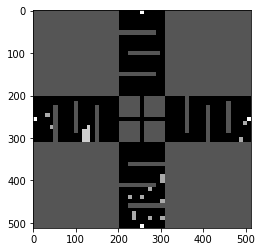

In [124]:
plt.imshow(env, cmap = 'gray')

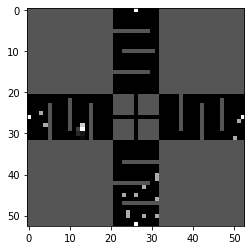

In [136]:
env = create_env(CORRIDOR_SHAPE, SEEDS)
tail = np.array(agent_xy[max(0, i-trajectory_tail):i+1])
tail = (tuple(tail[:,0]), tuple(tail[:,1]))

trajectory = np.array(agent_xy[:i+1])
trajectory = (tuple(trajectory[:,0]), tuple(trajectory[:,1]))

env[trajectory] = 0
env[tail] = EXIT_MAP_VALUE * alphas[-min(trajectory
env = (env - env.min())/env.max()
#env = np.array(Image.fromarray(env).resize((512, 512)))
plt.imshow(env, cmap = 'gray')

In [132]:
i

4471

In [129]:
len(tail)

2